In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from datetime import datetime
from urllib.parse import urlparse
from collections import Counter
import networkx as nx

In [28]:
with open("original.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Peek at the first 15 lines
for line in lines[:15]:
    print(repr(line))


'Summary,,,,,,,,,\n'
'OrgId,ParticipantId,DeviceId,InstalledDate,AcceptanceDate,Extension,BrowsingCount,BookmarkCount,CookieCount,\n'
'py_demo_client,demoUser@py-insights.com,2nwjevbvxzm7ehb254,2025-02-20T23:58:02-08:00,2025-02-20T23:58:20-08:00,Chrome,5104,0,0,\n'
',,,,,,,,,\n'
'Browsing,,,,,,,,,\n'
'OrgId,ParticipantId,DeviceId,url,eventtimeutc,transition,title,visitId,referringVisitId,eventtime\n'
'py_demo_client,demo,2nwjevbvxzm7ehb254,chrome-extension://hkmmnfimlpcphpgnmgdecpdpaefjnlga/snapshot.html,2025-02-21T07:58:02.688Z,link,,166328,0,2025-02-20T23:58:02-08:00\n'
'py_demo_client,demo,2nwjevbvxzm7ehb254,https://chromewebstore.google.com/detail/snapshot/hkmmnfimlpcphpgnmgdecpdpaefjnlga?orgId=py_demo_client&product=snapshot&participantId=user@email.com&pli=1,2025-02-21T07:57:51.308Z,link,Snapshot - Chrome Web Store,166327,166326,2025-02-20T23:57:51-08:00\n'
'py_demo_client,demo,2nwjevbvxzm7ehb254,https://py-insights.com/account/demo/product?source=d_snapshot,2025-02-21T07:57:40.9

In [ ]:
from io import StringIO

# Read entire file as lines
with open("original.csv", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Buffers for each section
summary_lines = []
browsing_lines = []

# Track section
current_section = None

for line in lines:
    line = line.strip()

    if line.startswith("Summary"):
        current_section = "summary"
        continue
    elif line.startswith("Browsing"):
        current_section = "browsing"
        continue
    elif line == "":
        continue

    if current_section == "summary":
        summary_lines.append(line)
    elif current_section == "browsing":
        browsing_lines.append(line)

# Load into dataframes
df_summary = pd.read_csv(StringIO("\n".join(summary_lines)))
df_browsing = pd.read_csv(StringIO("\n".join(browsing_lines)))

# Preview
print("Summary shape:", df_summary.shape)
print("Browsing shape:", df_browsing.shape)


Summary shape: (2, 10)
Browsing shape: (5104, 10)


In [30]:
df_browsing.describe()

,visitId,referringVisitId
count,5104.000000,5104.000000
mean,163242.251176,69253.185345
std,1742.403924,80736.587400
min,160209.000000,0.000000
25%,161752.750000,0.000000
50%,163204.500000,0.000000
75%,164742.250000,162931.000000
max,166328.000000,166326.000000


In [ ]:
# Data preview
print(df_browsing.head())

            OrgId ParticipantId            DeviceId  \
0  py_demo_client          demo  2nwjevbvxzm7ehb254   
1  py_demo_client          demo  2nwjevbvxzm7ehb254   
2  py_demo_client          demo  2nwjevbvxzm7ehb254   
3  py_demo_client          demo  2nwjevbvxzm7ehb254   
4  py_demo_client          demo  2nwjevbvxzm7ehb254   

                                                 url  \
0  chrome-extension://hkmmnfimlpcphpgnmgdecpdpaef...   
1  https://chromewebstore.google.com/detail/snaps...   
2  https://py-insights.com/account/demo/product?s...   
3  https://py-insights.com/account/demo/product?s...   
4       https://py-insights.com/account/demo/product   

               eventtimeutc transition                        title  visitId  \
0  2025-02-21T07:58:02.688Z       link                          NaN   166328   
1  2025-02-21T07:57:51.308Z       link  Snapshot - Chrome Web Store   166327   
2  2025-02-21T07:57:40.972Z       link        PY Insights | Product   166319   
3  2025-02-2

In [32]:
print(df_browsing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   OrgId             5104 non-null   object
 1   ParticipantId     5104 non-null   object
 2   DeviceId          5104 non-null   object
 3   url               5104 non-null   object
 4   eventtimeutc      5104 non-null   object
 5   transition        5104 non-null   object
 6   title             5051 non-null   object
 7   visitId           5104 non-null   int64 
 8   referringVisitId  5104 non-null   int64 
 9   eventtime         5104 non-null   object
dtypes: int64(2), object(8)
memory usage: 398.9+ KB
None


In [33]:
print(df_browsing.isnull().sum())

OrgId                0
ParticipantId        0
DeviceId             0
url                  0
eventtimeutc         0
transition           0
title               53
visitId              0
referringVisitId     0
eventtime            0
dtype: int64


In [34]:
# Dropping na values
df_browsing = df_browsing.dropna(subset=['title'])

In [35]:
# Convert to datetime
df_browsing['eventtimeutc'] = pd.to_datetime(df_browsing['eventtimeutc'], utc=True)
df_browsing['eventtime'] = pd.to_datetime(df_browsing['eventtime'])

# Extract features
df_browsing['hour'] = df_browsing['eventtime'].dt.hour
df_browsing['day_of_week'] = df_browsing['eventtime'].dt.day_name()
df_browsing['date'] = df_browsing['eventtime'].dt.date

# Extract domain
def get_domain(url):
    parsed = urlparse(url)
    return parsed.netloc

df_browsing['domain'] = df_browsing['url'].apply(get_domain)

# Preview updated dataframe
print(df_browsing[['eventtime', 'hour', 'day_of_week', 'domain']].head())


                  eventtime  hour day_of_week                     domain
1 2025-02-20 23:57:51-08:00    23    Thursday  chromewebstore.google.com
2 2025-02-20 23:57:40-08:00    23    Thursday            py-insights.com
3 2025-02-20 23:57:40-08:00    23    Thursday            py-insights.com
4 2025-02-20 23:57:38-08:00    23    Thursday            py-insights.com
5 2025-02-20 23:57:40-08:00    23    Thursday            py-insights.com


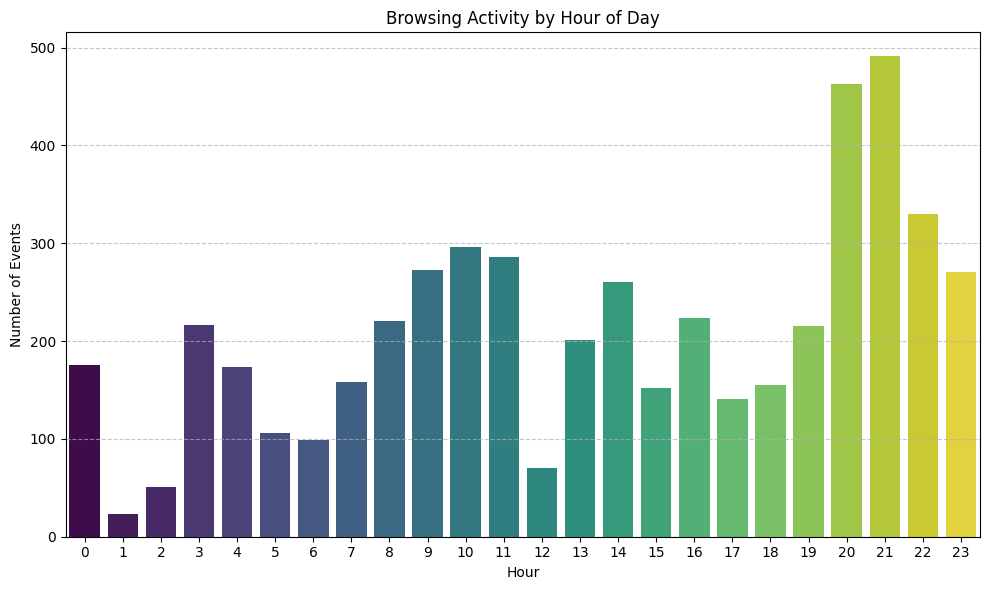

In [36]:
# Browsing by hour
plt.figure(figsize=(10, 6))
sns.countplot(data=df_browsing, x='hour', palette='viridis', hue='hour', legend=False)
plt.title('Browsing Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Events')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

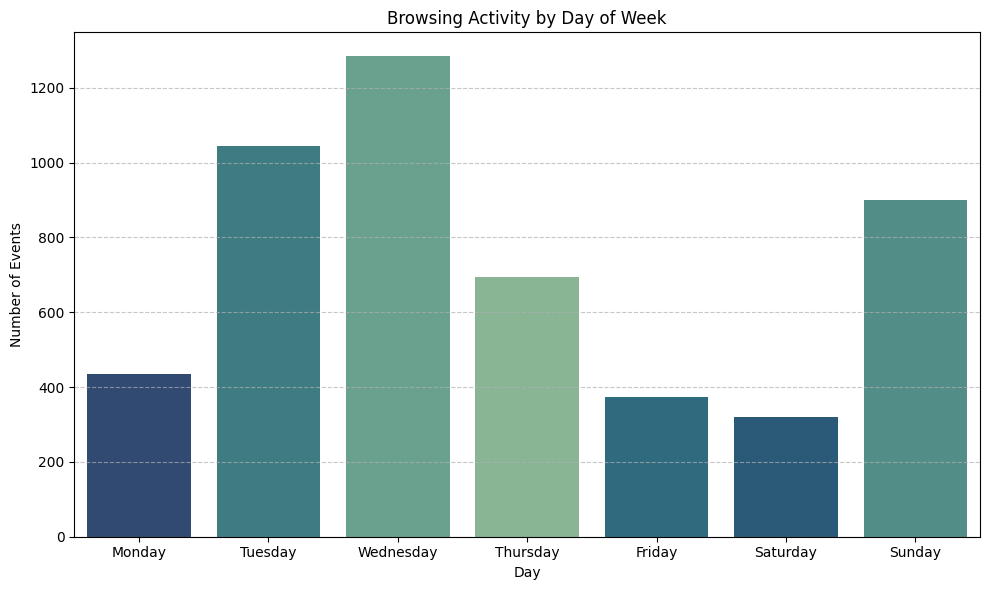

In [37]:
# Browsing by day of week (ordered)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.countplot(data=df_browsing, x='day_of_week', order=day_order, palette='crest', hue='day_of_week', legend=False)
plt.title('Browsing Activity by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Events')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_15264\3848898894.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_domains.values, y=top_domains.index, palette='magma')


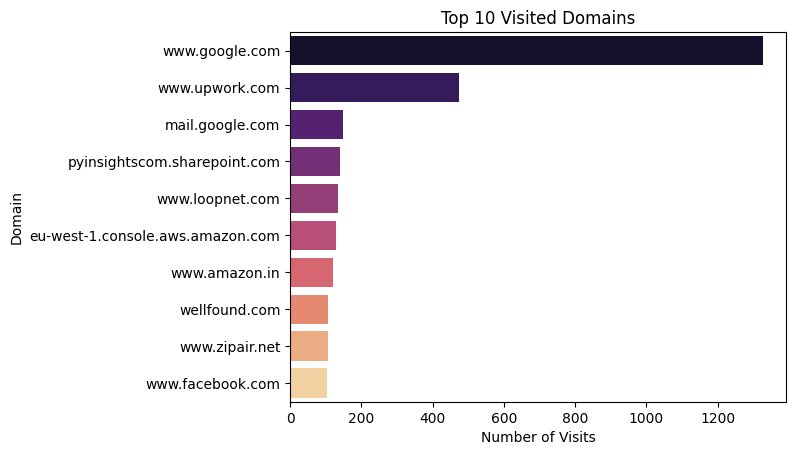

In [38]:
# Top 10 visited domains
top_domains = df_browsing['domain'].value_counts().head(10)
sns.barplot(x=top_domains.values, y=top_domains.index, palette='magma')
plt.title('Top 10 Visited Domains')
plt.xlabel('Number of Visits')
plt.ylabel('Domain')
plt.show()

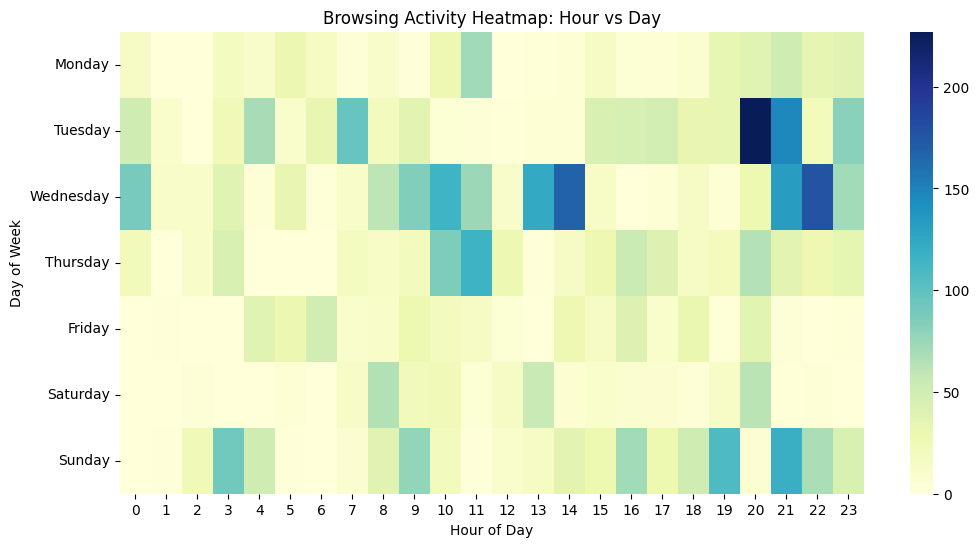

In [39]:
# Hour vs Day
heatmap_data = df_browsing.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.loc[day_order], cmap="YlGnBu")
plt.title("Browsing Activity Heatmap: Hour vs Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_15264\3283490881.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_browsing, x='transition', order=df_browsing['transition'].value_counts().index, palette='coolwarm')


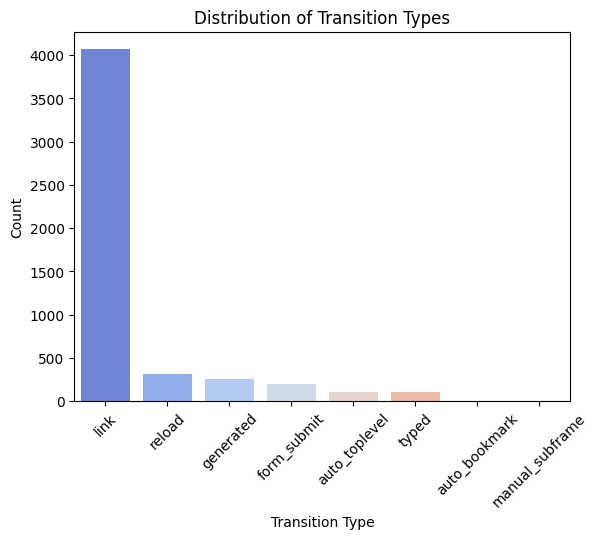

In [40]:
sns.countplot(data=df_browsing, x='transition', order=df_browsing['transition'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Transition Types')
plt.xlabel('Transition Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_15264\1427903426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_titles.values, y=top_titles.index, palette='viridis')


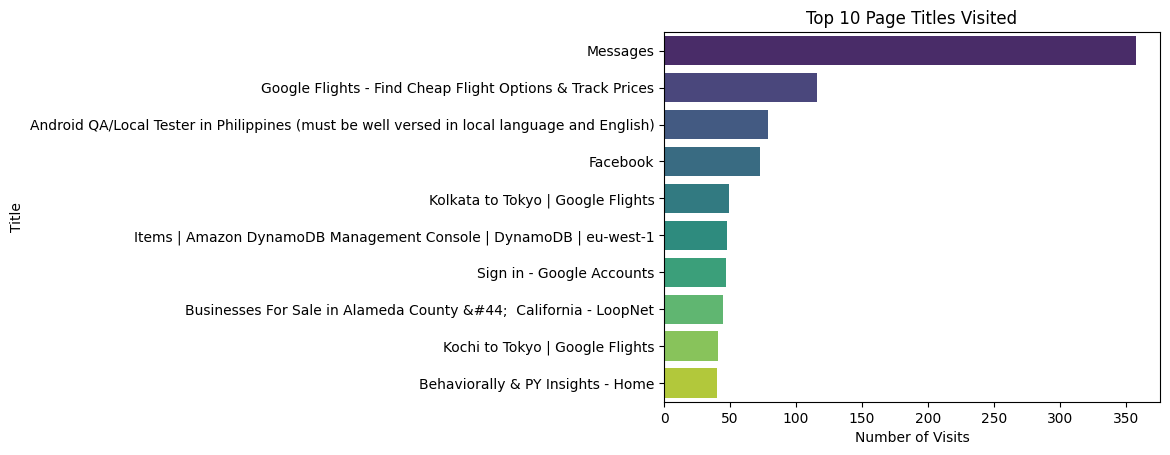

In [41]:
# Most Viewed Pages
top_titles = df_browsing['title'].value_counts().dropna().head(10)
sns.barplot(x=top_titles.values, y=top_titles.index, palette='viridis')
plt.title('Top 10 Page Titles Visited')
plt.xlabel('Number of Visits')
plt.ylabel('Title')
plt.show()

# Session Detection

In [42]:
# Convert to datetime
df_browsing['eventtimeutc'] = pd.to_datetime(df_browsing['eventtimeutc'], utc=True)
df_browsing['eventtime'] = pd.to_datetime(df_browsing['eventtime'])

In [ ]:
# Sort by eventtime
df_browsing = df_browsing.sort_values(by='eventtime').reset_index(drop=True)

# Define session length
session_timeout = pd.Timedelta(minutes=30)

# Calculate time difference between each visit
df_browsing['time_diff'] = df_browsing['eventtime'].diff()

# Flagging start of a new session
df_browsing['new_session'] = (df_browsing['time_diff'] > session_timeout) | (df_browsing['time_diff'].isnull())

# Assign session IDs
df_browsing['session_id'] = df_browsing['new_session'].cumsum()


In [44]:
# Total sessions
num_sessions = df_browsing['session_id'].nunique()
print(f"Total sessions: {num_sessions}")

Total sessions: 268


In [45]:
# Pages per session
session_lengths = df_browsing.groupby('session_id').size()
print(session_lengths.describe())

count    268.000000
mean      18.847015
std       36.012208
min        1.000000
25%        2.000000
50%        7.000000
75%       18.000000
max      328.000000
dtype: float64


In [46]:
# Session duration stats
session_durations = df_browsing.groupby('session_id')['eventtimeutc'].agg(['min', 'max'])
session_durations['duration'] = (session_durations['max'] - session_durations['min']).dt.total_seconds() / 60  # in minutes

print(session_durations['duration'].describe())

count    268.000000
mean      17.438809
std       32.483568
min        0.000000
25%        0.066333
50%        3.083008
75%       21.310171
max      270.098933
Name: duration, dtype: float64


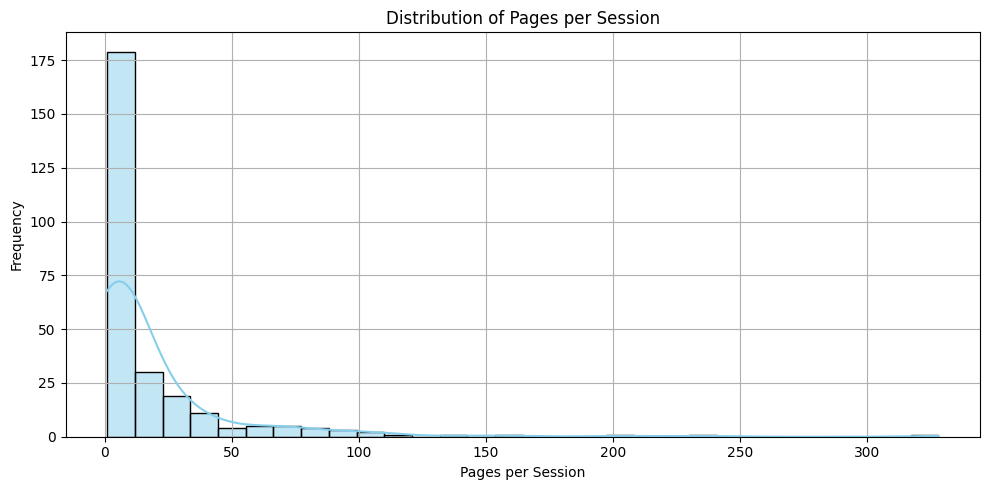

In [47]:
# Pages per session distribution

session_lengths = df_browsing.groupby('session_id').size()
plt.figure(figsize=(10, 5))
sns.histplot(session_lengths, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Pages per Session')
plt.xlabel('Pages per Session')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

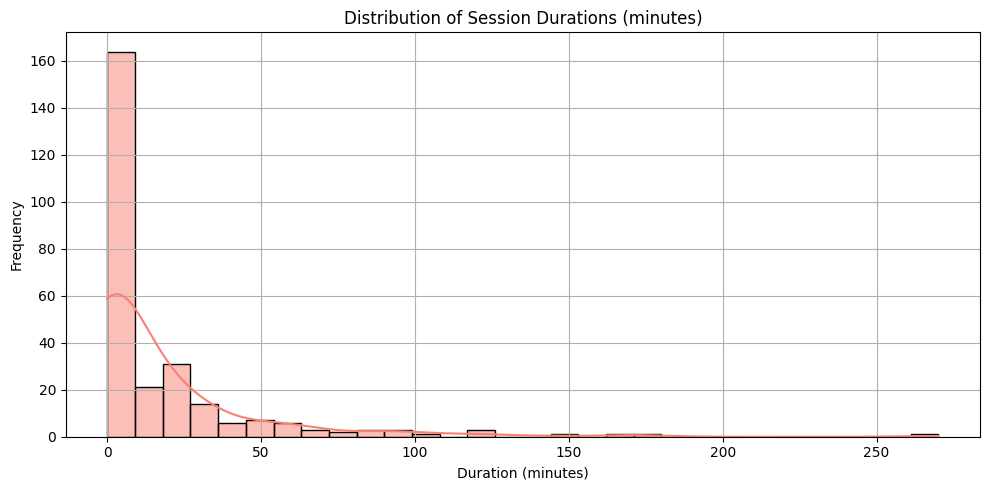

In [48]:
# Session duration distribution
plt.figure(figsize=(10, 5))
sns.histplot(session_durations['duration'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Session Durations (minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Nikhil\AppData\Local\Temp\ipykernel_15264\2196189991.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_browsing.drop_duplicates('session_id'), x='session_hour', palette='crest')


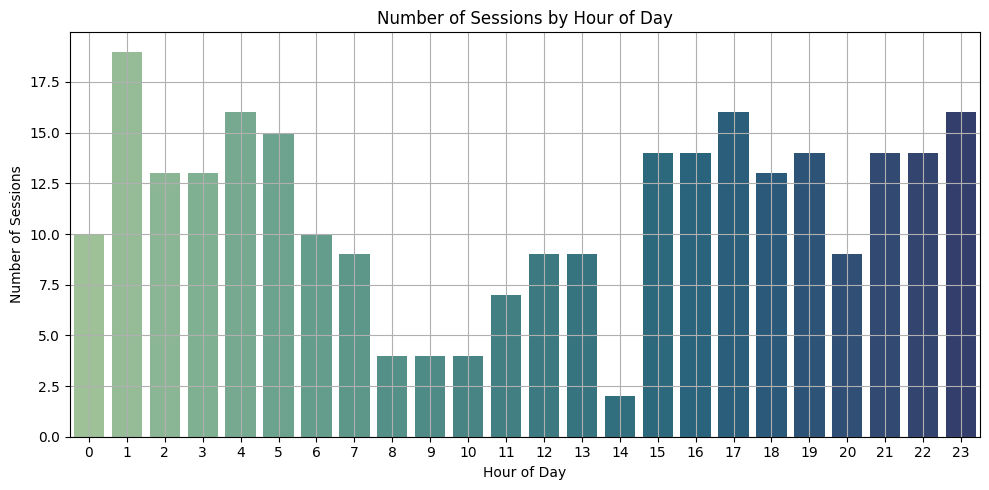

In [49]:
# Number of sessions by hour of day
df_browsing['session_start_time'] = df_browsing.groupby('session_id')['eventtimeutc'].transform('min')
df_browsing['session_hour'] = df_browsing['session_start_time'].dt.hour

plt.figure(figsize=(10, 5))
sns.countplot(data=df_browsing.drop_duplicates('session_id'), x='session_hour', palette='crest')
plt.title('Number of Sessions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_15264\1855708587.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_domains.index, x=top_domains.values, palette='viridis')


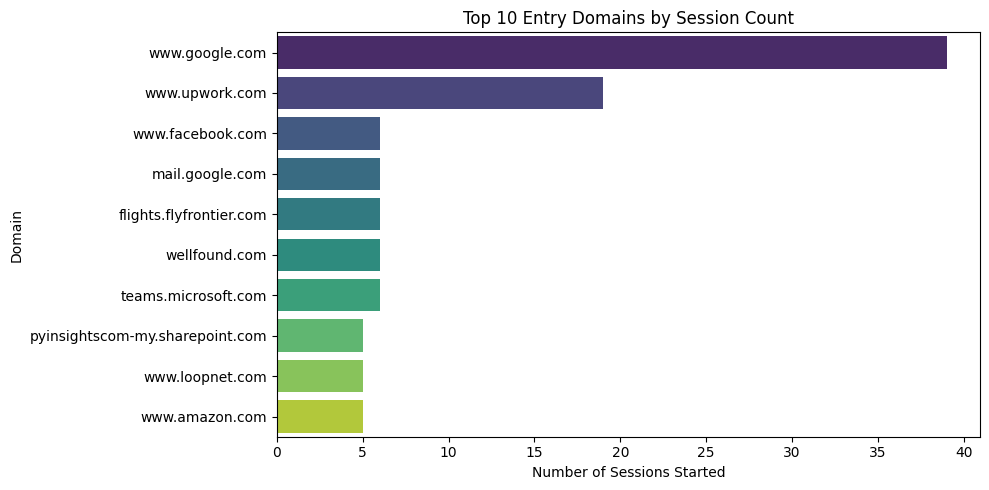

In [50]:
# Top domains by sessions started
df_browsing['domain'] = df_browsing['url'].str.extract(r'https?://([^/]+)')
first_visits = df_browsing.sort_values('eventtimeutc').groupby('session_id').first()

top_domains = first_visits['domain'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_domains.index, x=top_domains.values, palette='viridis')
plt.title('Top 10 Entry Domains by Session Count')
plt.xlabel('Number of Sessions Started')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_15264\3787294501.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_duration.index, y=avg_duration.values, palette='coolwarm')


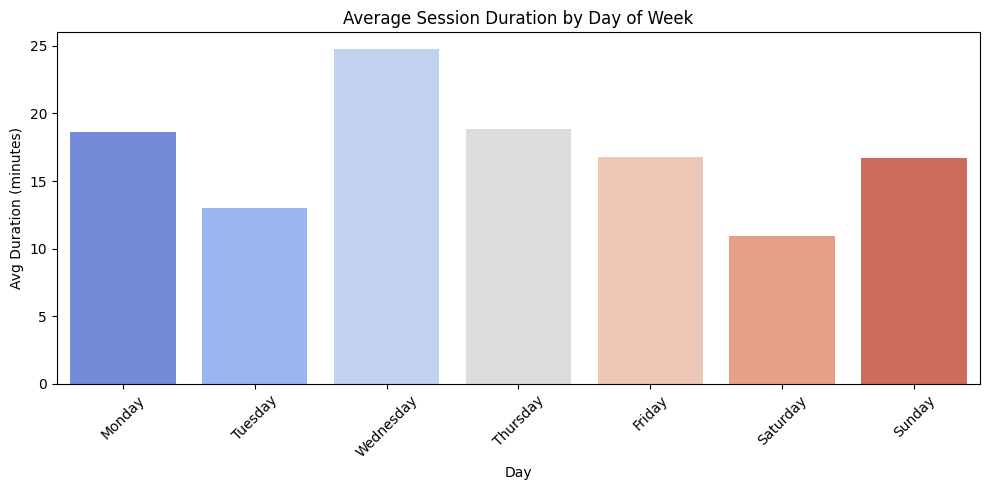

In [51]:
# Average Session Duration by Day of Week
first_visits['day_of_week'] = first_visits['eventtimeutc'].dt.day_name()
avg_duration = session_durations['duration'].groupby(first_visits['day_of_week']).mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_duration.index, y=avg_duration.values, palette='coolwarm')
plt.title('Average Session Duration by Day of Week')
plt.xlabel('Day')
plt.ylabel('Avg Duration (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()